In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

Device used: cuda
Model with 6 layers. Displaying layer #0
Starting training.


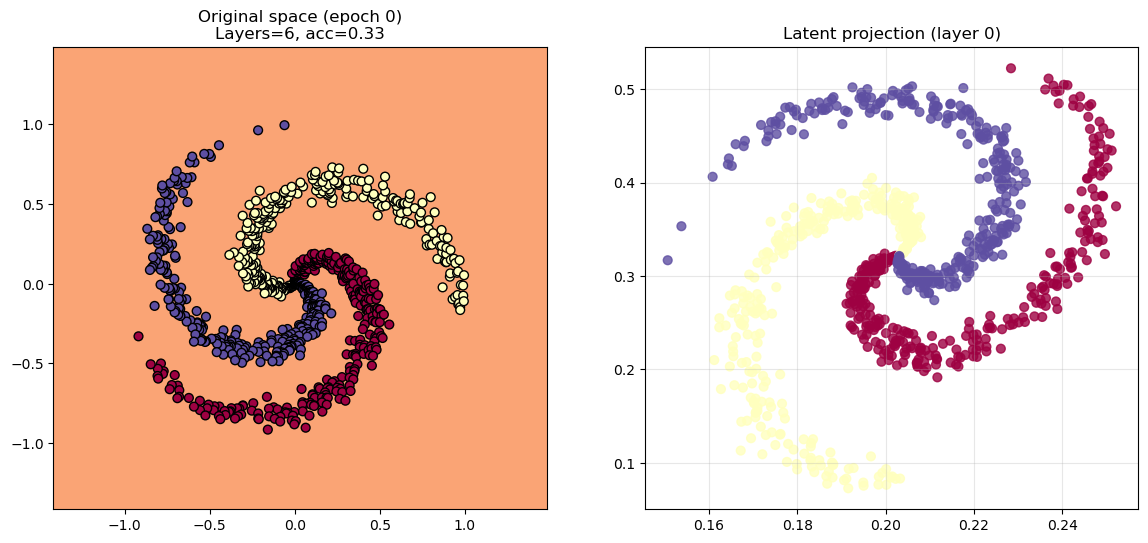

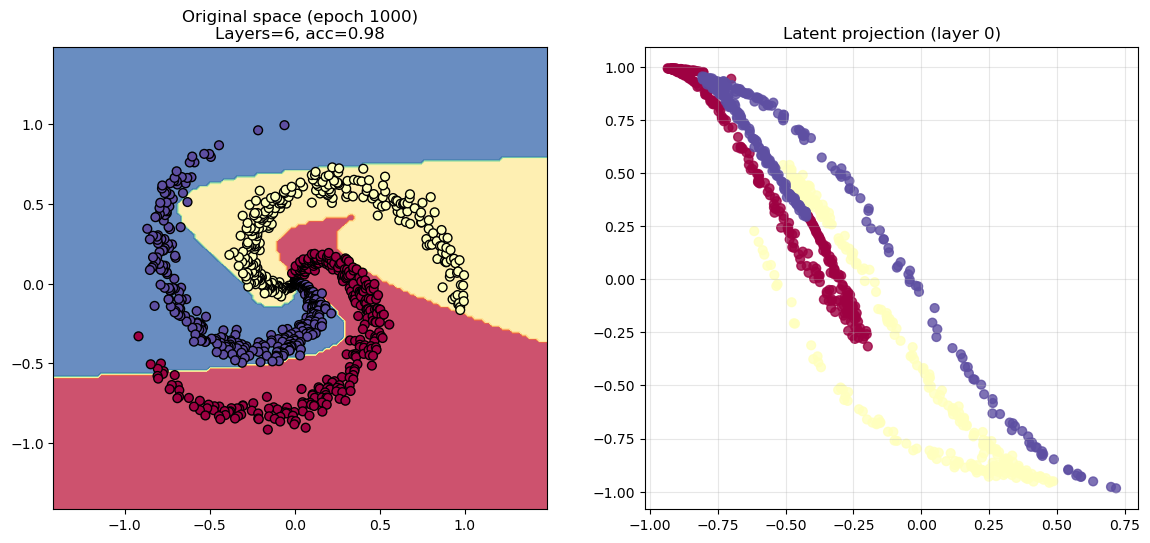

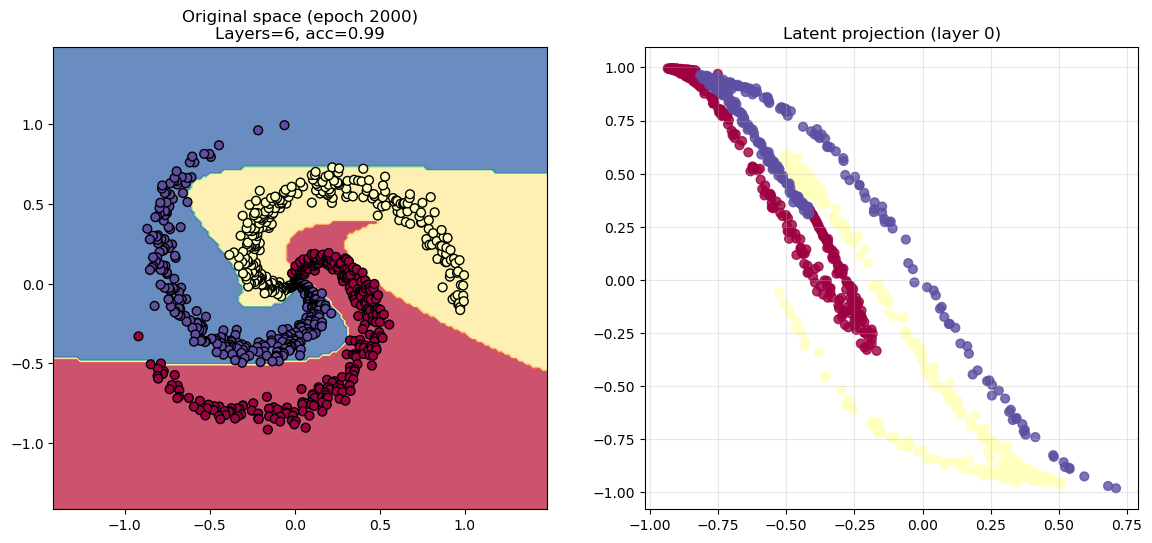

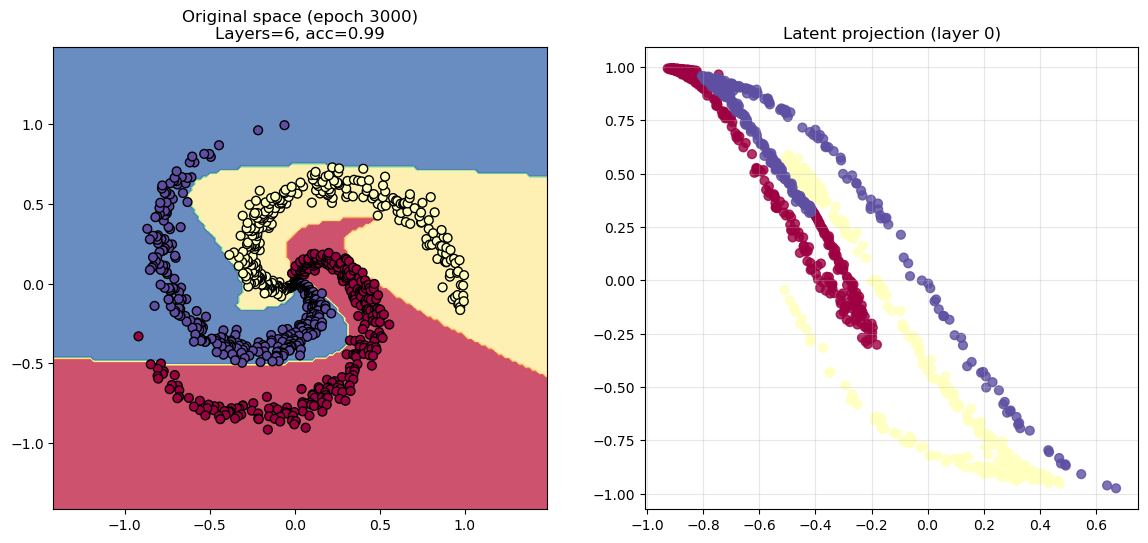

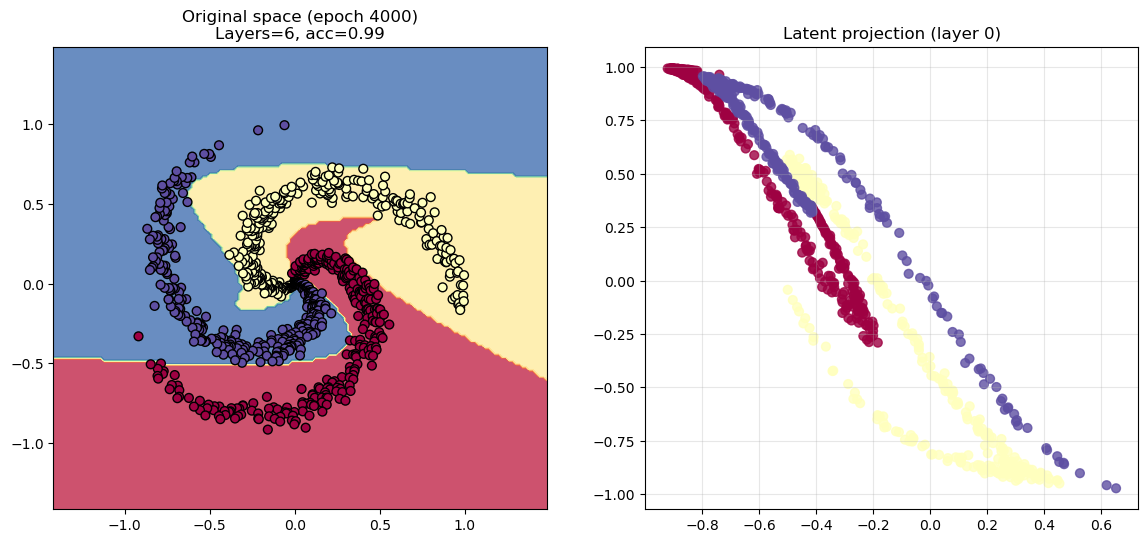

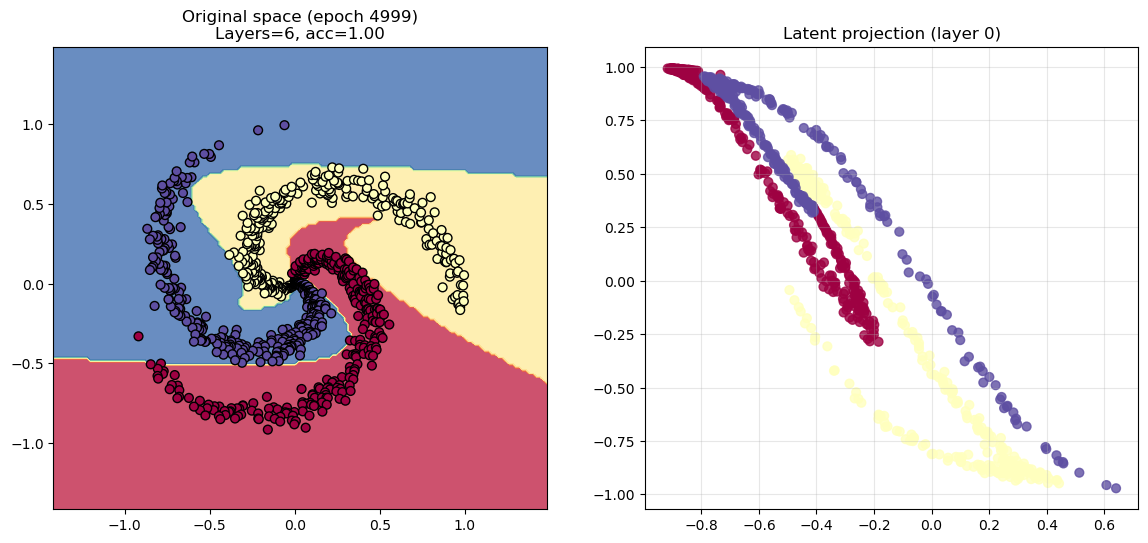

Final accuracy: 1.00


In [ ]:
# ========================================
# Configuration
# ========================================

numHiddenLayers = 6      # Number of hidden layers
layerToShow     = 0      # 0 to show the first layer, (numHiddenLayers - 1) for the last
learningRate    = 0.01   # Learning rate
weightDecay     = 1e-4   # L2 regularization
numEpochs       = 5000   # Number of iterations
plotEvery       = 1000   # Plotting frequency for the graphs

# ========================================
# Data generation and tools (taken from previous hands-on)
# ========================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device used: {device}")

def toySpiral3(N=200, K=3, D=2):
    """
    Generates a K-class (3 by default) spiral dataset (taken from previous hands-on).
    
    :param N: Number of points per class
    :param K: Number of classes
    :param D: Dimensionality of the data
    """
    np.random.seed(0)
    x = np.zeros((N*K,D))
    y = np.zeros(N*K, dtype='uint8')
    for j in range(K):
        ix = range(N*j,N*(j+1))
        r = np.linspace(0.0,1,N)
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        x[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    return x, y

def plotDecisionBoundaries(x, y, modelPredictFunc, plot=True, title=""):
    """
    Plot decision boundaries of a model (taken from previous hands-on).
    
    :param x: Input data points
    :param y: Labels corresponding to the data points
    :param modelPredictFunc: Function that takes input data and returns model predictions
    :param plot: Whether to display the plot
    :param title: Title of the plot
    """
    h = 0.02
    xMin, xMax = x[:, 0].min() - 0.5, x[:, 0].max() + 0.5
    yMin, yMax = x[:, 1].min() - 0.5, x[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    gridTensor = np.c_[xx.ravel(), yy.ravel()]
    Z = modelPredictFunc(gridTensor)
    Z = Z.reshape(xx.shape)
    
    if plot:
        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
        plt.scatter(x[:, 0], x[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolors='k')
        plt.title(title)

# ========================================
# Model definition
# ========================================

class SpiralNet(nn.Module):
    def __init__(self, numHiddenLayers, layerToShow):
        super(SpiralNet, self).__init__()
        self.layerToShow = layerToShow # store which layer to display
        self.hiddenLayers = nn.ModuleList()
        
        # Input layer (grouped with tanh for counting)
        self.hiddenLayers.append(nn.Sequential(nn.Linear(2, 2), nn.Tanh()))
        
        # Additional hidden layers
        for _ in range(numHiddenLayers - 1):
            self.hiddenLayers.append(nn.Sequential(nn.Linear(2, 2), nn.Tanh()))
            
        # Output layer
        self.outputLayer = nn.Linear(2, 3) 

    def forward(self, x):
        visualization = None # to store what we want to visualize

        # We save the layer we want
        for i, layer in enumerate(self.hiddenLayers):
            x = layer(x)
            if i == self.layerToShow:
                visualization = x
        
        # If a layer index out of bounds is requested, take the last one for safety
        if visualization is None:
            visualization = x

        logits = self.outputLayer(x)
        
        return logits, visualization

# Wrapper for visualization
def predictWrapper(x_numpy):
    """
    Wrapper function to convert numpy input to tensor, perform model prediction, and convert the output back to numpy.
    """
    xTensor = torch.from_numpy(x_numpy).float().to(device)
    with torch.no_grad():
        logits, _ = model(xTensor)
        preds = torch.argmax(logits, dim=1)
    return preds.cpu().numpy()

# ========================================
# Training loop
# ========================================

xNP, yNP = toySpiral3(N=300)
x = torch.tensor(xNP, dtype=torch.float32).to(device)
y = torch.tensor(yNP, dtype=torch.long).to(device)

# Model creation
print(f"Model with {numHiddenLayers} layers. Displaying layer #{layerToShow}")
model = SpiralNet(numHiddenLayers=numHiddenLayers, layerToShow=layerToShow).to(device)

optimizer = optim.Adam(model.parameters(), lr=learningRate, weight_decay=weightDecay)
criterion = nn.CrossEntropyLoss()

print("Starting training.")

for epoch in range(numEpochs):
    # Forward and backward pass
    logits, hiddenProj = model(x)
    loss = criterion(logits, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Visualization
    if epoch % plotEvery == 0 or epoch == numEpochs - 1:
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        hiddenData = hiddenProj.detach().cpu().numpy()
        
        plt.figure(figsize=(14, 6))
        
        # Original space
        plt.subplot(1, 2, 1)
        plotDecisionBoundaries(xNP, yNP, predictWrapper, 
                               title=f"Original space (epoch {epoch})\nLayers={numHiddenLayers}, acc={acc:.2f}")
        
        # Chosen layer in latent space
        plt.subplot(1, 2, 2)
        plt.scatter(hiddenData[:, 0], hiddenData[:, 1], c=yNP, cmap=plt.cm.Spectral, s=40, alpha=0.8)
        plt.title(f"Latent projection (layer {layerToShow})")
        plt.grid(True, alpha=0.3)
        
        plt.show()

print(f"Final accuracy: {acc:.2f}")